## Inicializacion e importe de librerias

In [3]:
%pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cpu


In [4]:
%pip install pydub scikit-learn wandb torchview torchviz graphviz matplotlib tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.6/248.6 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 10.2 MB/s eta 0:00:00
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4133 sha256=2f7abcf40a302f0c4d1cd7ef5575c8706f0bba17fec2234350ae36bbbceeb529
  Stored in directory: /root/.cache/pip/wheels/4c/97/88/a02973217949e0db0c9f4346d154085f4725f99c4f15a87094
Successfully built torchviz


In [5]:
%pip install wandb

In [6]:
!pip install torchaudio
!pip install  pydub
import os
import torch
import torchaudio
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchaudio.datasets import GTZAN
from torch.utils.data import DataLoader
import torchaudio.transforms as tt
from torch.utils.data import random_split
import matplotlib
import matplotlib.pyplot as plt
import IPython
from tqdm import tqdm
import gc
from sklearn.metrics import accuracy_score, confusion_matrix


import wandb
wandb.login()
%matplotlib inline


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


bfbad9b2649155692b5f97a49a43c0eeb66dff4a

In [7]:
device = torch.device(
    'mps:0' if torch.backends.mps.is_available() else 'cuda:0' if torch.cuda.is_available() else 'cpu'
    )

device

device(type='cuda', index=0)


# TP4: Encodeador de música



## Orden de pasos

0. Elijan GPU para que corra mas rapido (RAM --> change runtime type --> T4 GPU)
1. Descargamos el dataset y lo descomprimimos en alguna carpeta en nuestro drive.
2. Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.
3. Visualización de los archivos
4. Clasificación
5. Evaluación




## BASE

In [8]:
project_name='Music_genre_classification'

### 2. Conectamos la notebook a gdrive y seteamos data_dir con el path a los archivos.





In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


data_dir es el path donde pusimos la carpeta genres. "'//content/drive/MyDrive/Materias/TD6 - Inteligencia Artificial/TPs/2023/TP4/genres/'" es un ejemplo. Modificar.

In [11]:
import os
data_dir='/content/drive/MyDrive/genres_5sec/'
list_files=os.listdir(data_dir)
classes=[]
for file in list_files:
  name='{}/{}'.format(data_dir,file)
  if os.path.isdir(name):
    classes.append(file)
classes

['rock',
 'pop',
 'hiphop',
 'disco',
 'blues',
 'reggae',
 'country',
 'metal',
 'classical',
 'jazz']

In [12]:
samplerate=22050
def parse_genres(fname):
    parts = fname.split('/')[-1].split('.')[0]
    return parts #' '.join(parts[0])

class MusicDataset(Dataset):
    def __init__(self, root):
        super().__init__()
        self.root = root
        self.files =[]
        for c in classes:
          self.files = self.files + [fname for fname in os.listdir(os.path.join(root,c)) if fname.endswith('.wav')]
        self.classes = list(set(parse_genres(fname) for fname in self.files))
        #self.transform = transform

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
            fname = self.files[i]

            #img = self.transform(open_image(fpath))
            genre = parse_genres(fname)
            fpath = os.path.join(self.root,genre, fname)
            genre_index = self.classes.index(genre)
            audio = torchaudio.load(fpath)[0]

            spectogram = tt.Spectrogram(
                n_fft=1024,
            )(audio)

            # MelSpectrogram tt.MelSpectrogram(sample_rate=samplerate, n_fft=1024, hop_length=512, n_mels=128)(audio)
            # mel_spectogram = tt.MelSpectrogram(sample_rate=samplerate, n_fft=1024, hop_length=200, n_mels=201)(audio)

            hop_length=432
            n_mels=256
            n_fft = 2*(n_mels - 1)

            mel_spectogram = tt.MelSpectrogram(sample_rate=samplerate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)(audio)

            return audio,spectogram, mel_spectogram, genre_index

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        fmt_str += '    Root Location: {}\n'.format(self.root)
        # List classes
        fmt_str += '    Classes: {}\n'.format(self.classes)
        return fmt_str
dataset = MusicDataset(data_dir)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Separamos en train y val

In [14]:
random_seed = 42
torch.manual_seed(random_seed);
val_size = 100
test_size = 100
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds),len(val_ds),len(test_ds)

(790, 100, 100)

In [15]:
from torch.utils.data import DataLoader
batch_size = 20

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds,1, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
audio, spectogram, mel_spectogram, class_idx = train_dl.dataset[12]
print("shape of waveform {}, sample rate with {}, label is {} ".format(audio.size(),samplerate,class_idx))

shape of waveform torch.Size([1, 110250]), sample rate with 22050, label is 3 


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


### 3. Visualización de los archivos

In [ ]:

waveform,spectogram, mel_spectogram,label= dataset[0]
print("shape of waveform {}, sample rate with {}, label is {} ".format(waveform.size(),samplerate,label))
# label = 9 es rock

In [ ]:

specgram=tt.Spectrogram()(waveform)
print("shape of spectogram {}".format(specgram.size()))

plt.figure(figsize=(20, 5))
plt.imshow(specgram.log2()[0,:,:].numpy(),cmap='magma')

In [ ]:
print("Waveform: {}\n".format(waveform))

plt.figure()
plt.plot(waveform.t().numpy())

Escuchamos el espectograma con la librería de audio

In [ ]:
import IPython
IPython.display.Audio(waveform,rate=samplerate)

In [ ]:
specgram.size()

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);
val_size = 100
test_size = 100
train_size = len(dataset) - val_size - test_size

train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds),len(val_ds),len(test_ds)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 20

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_dl = DataLoader(test_ds,1, num_workers=4, pin_memory=True)

## **Ejercicio 1**

### Autoencoder

In [1]:

class Autoencoder(nn.Module):
    def __init__(self, n_input=1, stride=16, n_channel=32):
        super(Autoencoder, self).__init__()

        # Encoder.
        self.enc_conv1 = nn.Conv1d(n_input, n_channel, kernel_size=3, padding=1, stride=3)
        self.pool1 = nn.MaxPool1d(4)
        self.enc_conv2 = nn.Conv1d(n_channel, n_channel*2, kernel_size=3, padding=1, stride=3)
        self.pool2 = nn.MaxPool1d(2)
        self.enc_conv3 = nn.Conv1d(n_channel*2, n_channel*2, kernel_size=3, padding=1, stride=3)

        # Decoder.
        self.dec_conv1 = nn.ConvTranspose1d(n_channel*2, n_channel*2, kernel_size=3, stride=2)
        self.dec_conv2 = nn.ConvTranspose1d(n_channel*2, n_channel, kernel_size=3, stride=4)
        self.dec_conv3 = nn.ConvTranspose1d(n_channel, n_input, kernel_size=3, stride=1)

    def forward_encoder(self, x):
        # print("Encoder input shape:", x.shape)
        x = F.tanh(self.enc_conv1(x))
        # print("Encoder Conv1 shape:", x.shape)
        x = self.pool1(x)
        # print("Encoder Pool1 shape:", x.shape)
        x = F.tanh(self.enc_conv2(x))
        # print("Encoder Conv2 shape:", x.shape)
        x = self.pool2(x)
        # print("Encoder Pool2 shape:", x.shape)
        x = F.tanh(self.enc_conv3(x))
        # print("Encoder Conv3 shape:", x.shape)
        return x

    def forward_decoder(self, x):
        x = F.tanh(self.dec_conv1(x))
        # print("Decoder Conv1 shape:", x.shape)
        x = F.tanh(self.dec_conv2(x))
        # print("Decoder Conv2 shape:", x.shape)
        x = self.dec_conv3(x)
        # print("Decoder Conv3 shape:", x.shape)
        return x

    def forward(self, x):
        x = self.forward_encoder(x)
        x = self.forward_decoder(x)
        return x


# Assuming your audio has shape [batch_size, channels, sequence_length]
audio_size = (batch_size, 1, 110250)  # Example shape
model = Autoencoder(n_input=audio_size[1]).to(device)
# Dummy input for testing
dummy_input = torch.rand(audio_size).to(device)
output = model(dummy_input)
print("Output shape:", output.size())
print(model)

NameError: ignored

In [ ]:

class Autoencoder(nn.Module):
    def __init__(self,n_input, ic1, ic2, ic3, ks1, ks2, ks3, s1, s2, s3, p1, p2, p3):
        super(Autoencoder, self).__init__()

        # Encoder.
        self.enc_conv1 = nn.Conv1d(n_input, ic1, kernel_size=ks1, padding=p1, stride=s1)
        # self.pool1 = nn.MaxPool1d(4)
        self.enc_conv2 = nn.Conv1d(ic1, ic2, kernel_size=ks2, padding=p2, stride=s2)
        # self.pool2 = nn.MaxPool1d(2)
        self.enc_conv3 = nn.Conv1d(ic2, ic3, kernel_size=ks3, padding=p3, stride=s3)

        # Decoder.
        self.dec_conv1 = nn.ConvTranspose1d(ic3, ic2, kernel_size=ks3, stride=s3)
        self.dec_conv2 = nn.ConvTranspose1d(ic2, ic1, kernel_size=ks2, stride=s2)
        self.dec_conv3 = nn.ConvTranspose1d(ic2, n_input, kernel_size=ks1, stride=s1)

    def forward_encoder(self, x):
        # print("Encoder input shape:", x.shape)
        x = F.tanh(self.enc_conv1(x))
        # print("Encoder Conv1 shape:", x.shape)
        # x = self.pool1(x)
        # print("Encoder Pool1 shape:", x.shape)
        x = F.tanh(self.enc_conv2(x))
        # print("Encoder Conv2 shape:", x.shape)
        # x = self.pool2(x)
        # print("Encoder Pool2 shape:", x.shape)
        x = F.tanh(self.enc_conv3(x))
        # print("Encoder Conv3 shape:", x.shape)
        return x

    def forward_decoder(self, x):
        x = F.tanh(self.dec_conv1(x))
        # print("Decoder Conv1 shape:", x.shape)
        x = F.tanh(self.dec_conv2(x))
        # print("Decoder Conv2 shape:", x.shape)
        x = self.dec_conv3(x) #podemos apicar tanh
        # print("Decoder Conv3 shape:", x.shape)
        return x

    def forward(self, x):
        x = self.forward_encoder(x)
        x = self.forward_decoder(x)
        return x


# Assuming your audio has shape [batch_size, channels, sequence_length]
audio_size = (batch_size, 1, 110250)  # Example shape
model = Autoencoder(n_input=audio_size[1]).to(device)
# Dummy input for testing
dummy_input = torch.rand(audio_size).to(device)
output = model(dummy_input)
print("Output shape:", output.size())
print(model)

In [20]:
def chequear_division_entera(ic1, ic2, ic3, ks1, ks2, ks3, s1, s2, s3, p1, p2, p3):
      d1 = (110250 + 2 * p1 - (ks1-1) - 1)

      if d1 % s1 != 0:
          print("d1= " + str(d1))
          return 0

      l_out1 = d1/s1 + 1

      print(f"primera capa= {l_out1*ic1}")

      d2 = (l_out1 + 2 * p2 - (ks2-1) - 1)

      if d2 % s2 != 0:
          print("d2= " + str(d2))
          return 0

      l_out2 = d2/s2 + 1

      print(f"segunda capa= {l_out2*ic2}")

      d3 = (l_out2 + 2 * p3 - (ks3-1) - 1)

      if d3 % s3 != 0:
          print("d3= " + str(d3))
          return 0

      l_out3 = d3/s3 + 1

      print(f"tercer capa= {l_out3*ic3}")

      return "debería funcar"

In [ ]:
chequear_division_entera

#### Entrenamos autoencoder

In [21]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
elif torch.backends.mps.is_available():
    torch.mps.empty_cache()

lr=0.005
num_epochs = 30
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
torch.cuda.empty_cache()
gc.collect() #importante para ir liberando memoria ram
valid_losses = []
train_accs = []
valid_accs = []

log = False


if log:
    wandb.init(
        project=project_name,
        name=f"{model.__class__.__name__}_lr={lr}_bs={batch_size}_epochs={num_epochs},{device}",
    )


for epoch in range(num_epochs):
  losses = []
  train_loss = []
  val_loss = []
  # TRAIN
  model.train()
  for data in train_dl:
      audio,spectogram, mel_spectogram, genre_index = data
      audio = audio.to(device)
      # print(audio.shape)

      # Forward
      out = model(audio)
      # ?
      loss = loss_function(out.squeeze(), audio.squeeze())

      # Backward
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      train_loss.append(loss.item())

      del spectogram #importante para ir liberando memoria ram
      del genre_index #importante para ir liberando memoria ram
      del audio #importante para ir liberando memoria ram
      del loss #importante para ir liberando memoria ram
      del out  #importante para ir liberando memoria ram
      torch.cuda.empty_cache()  #importante para ir liberando memoria ram
      gc.collect() #importante para ir liberando memoria ram

  print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(train_loss)))

  # VALIDATION
  model.eval()
  correct =0
  for data in valid_dl:
      audio,spectogram, mel_spectogram, genre_index = data
      audio = audio.to(device)
      # print(audio.shape)

      # Forward
      out = model(audio)
      # ?
      loss = loss_function(out.squeeze(), audio.squeeze())

      val_loss.append(loss.item())

      del spectogram #importante para ir liberando memoria ram
      del genre_index #importante para ir liberando memoria ram
      del audio #importante para ir liberando memoria ram
      del loss #importante para ir liberando memoria ram
      del out  #importante para ir liberando memoria ram
      torch.cuda.empty_cache()  #importante para ir liberando memoria ram
      gc.collect() #importante para ir liberando memoria ram

  valid_loss = np.mean(val_loss)
  print('Epoch: [%d/%d], Valid loss: %.4f' % (epoch+1, num_epochs, valid_loss))

  # Save model
  valid_losses.append(valid_loss.item())
  if np.argmin(valid_losses) == epoch:
      print('Saving the best model at %d epochs!' % epoch)
      torch.save(model.state_dict(), 'best_model.ckpt')

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.war

Epoch: [1/30], Train loss: 0.0389


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [1/30], Valid loss: 0.0092
Saving the best model at 0 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [2/30], Train loss: 0.0082


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [2/30], Valid loss: 0.0061
Saving the best model at 1 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [3/30], Train loss: 0.0062


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [3/30], Valid loss: 0.0050
Saving the best model at 2 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [4/30], Train loss: 0.0054


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [4/30], Valid loss: 0.0046
Saving the best model at 3 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [5/30], Train loss: 0.0049


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [5/30], Valid loss: 0.0042
Saving the best model at 4 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [6/30], Train loss: 0.0046


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [6/30], Valid loss: 0.0040
Saving the best model at 5 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [7/30], Train loss: 0.0044


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [7/30], Valid loss: 0.0039
Saving the best model at 6 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [8/30], Train loss: 0.0042


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [8/30], Valid loss: 0.0037
Saving the best model at 7 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [9/30], Train loss: 0.0041


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [9/30], Valid loss: 0.0036
Saving the best model at 8 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [10/30], Train loss: 0.0040


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [10/30], Valid loss: 0.0035
Saving the best model at 9 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [11/30], Train loss: 0.0039


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [11/30], Valid loss: 0.0034
Saving the best model at 10 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [12/30], Train loss: 0.0037


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [12/30], Valid loss: 0.0033
Saving the best model at 11 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [13/30], Train loss: 0.0036


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [13/30], Valid loss: 0.0032
Saving the best model at 12 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [14/30], Train loss: 0.0035


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [14/30], Valid loss: 0.0031
Saving the best model at 13 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [15/30], Train loss: 0.0034


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [15/30], Valid loss: 0.0030
Saving the best model at 14 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [16/30], Train loss: 0.0033


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [16/30], Valid loss: 0.0030
Saving the best model at 15 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [17/30], Train loss: 0.0033


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [17/30], Valid loss: 0.0029
Saving the best model at 16 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [18/30], Train loss: 0.0032


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [18/30], Valid loss: 0.0029


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [19/30], Train loss: 0.0032


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [19/30], Valid loss: 0.0028
Saving the best model at 18 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [20/30], Train loss: 0.0031


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [20/30], Valid loss: 0.0028
Saving the best model at 19 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [21/30], Train loss: 0.0031


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [21/30], Valid loss: 0.0028
Saving the best model at 20 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [22/30], Train loss: 0.0031


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [22/30], Valid loss: 0.0027
Saving the best model at 21 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [23/30], Train loss: 0.0031


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [23/30], Valid loss: 0.0027
Saving the best model at 22 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [24/30], Train loss: 0.0030


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [24/30], Valid loss: 0.0027
Saving the best model at 23 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [25/30], Train loss: 0.0030


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [25/30], Valid loss: 0.0026
Saving the best model at 24 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [26/30], Train loss: 0.0029


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [26/30], Valid loss: 0.0026
Saving the best model at 25 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [27/30], Train loss: 0.0029


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [27/30], Valid loss: 0.0026


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [28/30], Train loss: 0.0028


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [28/30], Valid loss: 0.0025
Saving the best model at 27 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [29/30], Train loss: 0.0028


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [29/30], Valid loss: 0.0025
Saving the best model at 28 epochs!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [30/30], Train loss: 0.0028


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


Epoch: [30/30], Valid loss: 0.0025
Saving the best model at 29 epochs!


In [22]:
# Load the best model
S = torch.load('best_model.ckpt')
model.load_state_dict(S)
print('loaded!')

# Run evaluation
model.eval()
y_true = []
y_pred = []
correct = 0
with torch.no_grad():
    for audio,spectogram, mel_spectogram, genre_index in test_dl:
        audio = audio.to(device)
        genre_index = genre_index.to(device)

        out = model(audio)

        pred= out.argmax(dim=-1).flatten()
        # append labels and predictions
        correct += pred.eq(genre_index).sum().item()
        y_true.extend(genre_index)
        y_pred.extend(pred)

accuracy =correct/ len(test_dl.dataset)
print('Epoch: [%d/%d], Valid loss: %.4f' % (epoch+1, num_epochs, valid_loss))


loaded!


/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value f

Epoch: [30/30], Valid loss: 0.0025


In [23]:
original = test_dl.dataset[12]
print(original)
audio = original[0]
idnex = original[3]
print("shape of waveform {}, sample rate with {}, label is {} ".format(audio.size(),samplerate,idnex))

(tensor([[-0.0334, -0.0404, -0.0234,  ..., -0.0197, -0.0273, -0.0298]]), tensor([[[1.0886e+00, 5.4210e-01, 4.3610e-01,  ..., 3.3306e-02,
          3.0983e-01, 2.1070e+00],
         [1.6215e-01, 1.4867e+00, 1.2907e+00,  ..., 1.0230e-01,
          7.8572e-01, 9.7148e-01],
         [1.0822e-01, 6.3511e-01, 1.0029e+00,  ..., 1.4857e-01,
          6.0099e-01, 5.2966e-01],
         ...,
         [4.2608e-04, 2.7227e-08, 4.0395e-08,  ..., 9.4400e-09,
          5.4528e-08, 5.6718e-08],
         [4.1799e-04, 8.4445e-09, 5.8733e-09,  ..., 1.4328e-08,
          4.2403e-08, 1.2298e-08],
         [4.1902e-04, 8.7402e-10, 5.1436e-10,  ..., 1.1264e-08,
          4.1336e-08, 2.2004e-09]]]), tensor([[[0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         ...,
     

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (256) may be set too low.
  warnings.warn(


In [24]:
import IPython
IPython.display.Audio(audio, rate=22050)

In [25]:
audio = audio.to(device)
print(audio.shape)

out = model(audio)

torch.Size([1, 110250])


In [26]:
import IPython
IPython.display.Audio(out.detach().cpu(), rate=22050)

<built-in method size of Tensor object at 0x7f61610ccc70>
spectogram shape:  torch.Size([1, 1, 513, 216])
reconstructed spectogram shape:  torch.Size([1, 513, 216])

mel_spectogram shape:  torch.Size([1, 1, 256, 256])
reconstructed mel_spectogram shape:  torch.Size([1, 256, 256])
waveform shape:  torch.Size([1, 1, 110250])
waveform new shape:  torch.Size([1, 110250])
Audio Original


Audio Reconstruido


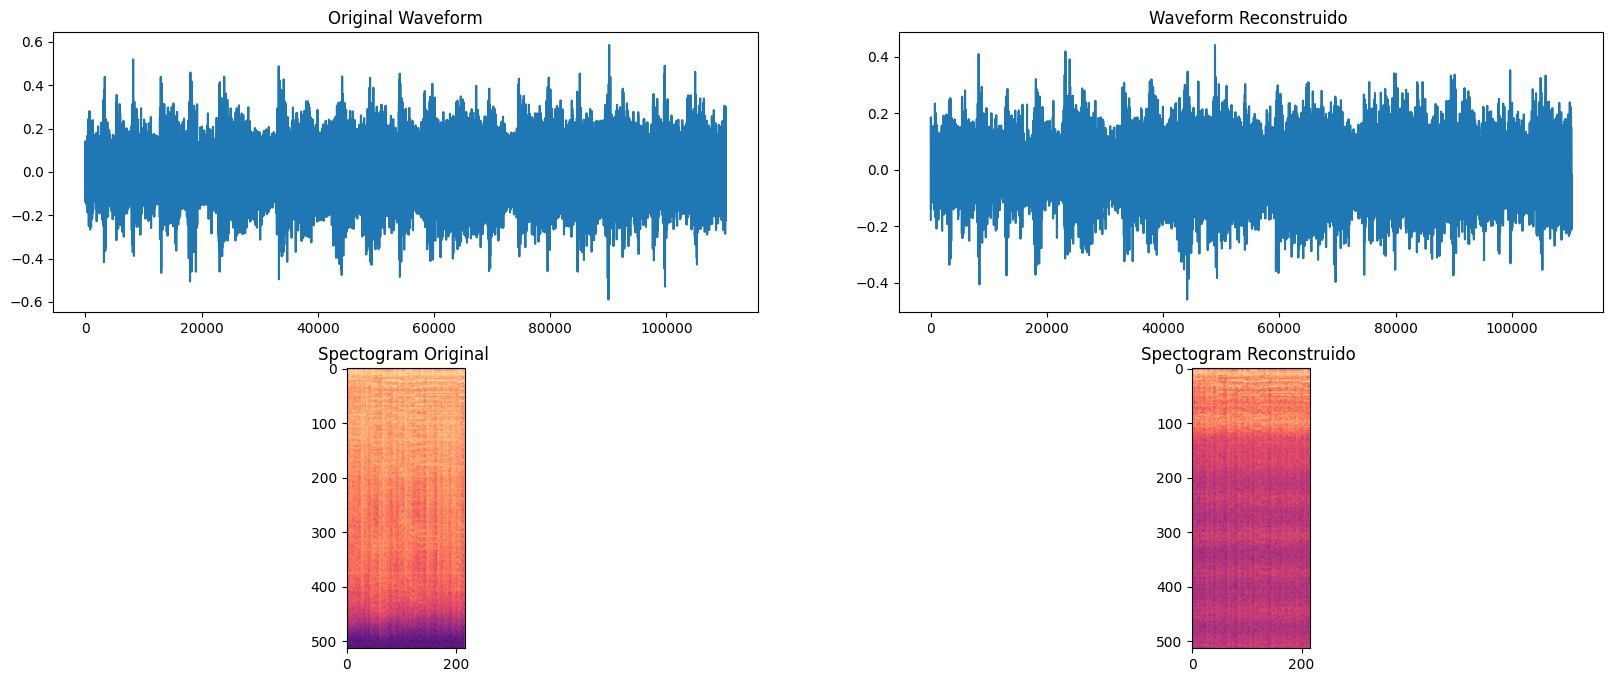

In [27]:
model.eval()
#original
waveform, spectogram, mel_spectogram, label = next(iter(test_dl))
print(waveform.size)
audio = waveform.to(device)
spec = spectogram.to(device)
#reconstruccion
rec_audio = model(audio).to('cpu').squeeze(0).detach()
rec_spec = tt.Spectrogram(n_fft=1024)(rec_audio)

print("spectogram shape: ", spectogram.shape)
print("reconstructed spectogram shape: ", rec_spec.shape)
print()
hop_length=432
n_mels=256
n_fft = 2*(n_mels - 1)

rec_mel_spec = tt.MelSpectrogram(sample_rate=samplerate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)(rec_audio)
mel_spect = mel_spectogram.to(device)

print("mel_spectogram shape: ", mel_spect.shape)
print("reconstructed mel_spectogram shape: ", rec_mel_spec.shape)

# rec_audio = rec_audio.sAqueeze(0)

print("waveform shape: ", waveform.shape)
print("waveform new shape: ", rec_audio.shape)


fig, axs = plt.subplots(2, 2, figsize=(20, 8))

axs[0, 0].plot(audio.squeeze().detach().cpu().numpy())
axs[0, 0].set_title("Original Waveform")

axs[0, 1].plot(rec_audio.t().numpy())
axs[0, 1].set_title("Waveform Reconstruido ")

axs[1, 0].imshow(spec.log2().squeeze().detach().cpu().numpy(), cmap='magma')
axs[1, 0].set_title("Spectogram Original ")

axs[1, 1].imshow(rec_spec.log2().squeeze().detach().cpu().numpy(), cmap='magma')
axs[1, 1].set_title("Spectogram Reconstruido ")

print("Audio Original")
display(IPython.display.Audio(waveform.squeeze(), rate=samplerate))
print("Audio Reconstruido")
display(IPython.display.Audio(rec_audio, rate=samplerate))

### UNet

In [ ]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        ##print(x.shape, skip.shape)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x
    # def forward(self, inputs, skip):
    #     x = self.up(inputs)
    #     # Ajuste de dimensiones
    #     diffY = skip.size()[2] - x.size()[2]
    #     diffX = skip.size()[3] - x.size()[3]

    #     x = F.pad(x, [diffX // 2, diffX - diffX // 2,
    #                   diffY // 2, diffY - diffY // 2])
    #     x = torch.cat([x, skip], axis=1)
    #     x = self.conv(x)
    #     return x

class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(1, 16)
        self.e2 = encoder_block(16, 32)
        self.e3 = encoder_block(32, 64)
        self.e4 = encoder_block(64, 128)

        # self.e1 = encoder_block(256, 128)
        # self.e2 = encoder_block(128, 64)
        # self.e3 = encoder_block(64, 32)
        # self.e4 = encoder_block(32, 16)

        """ Bottleneck """
        #self.b = conv_block(16, 32)
        self.b = conv_block(128, 256)
        """ Decoder """
        self.d1 = decoder_block(256, 128)
        self.d2 = decoder_block(128, 64)
        self.d3 = decoder_block(64, 32)
        self.d4 = decoder_block(32, 16)

        # self.d1 = decoder_block(32, 64)
        # self.d2 = decoder_block(64, 128)
        # self.d3 = decoder_block(128, 256)
        # self.d4 = decoder_block(256, 512)

        """ Classifier """
        self.outputs = nn.Conv2d(16, 1, kernel_size=1, padding=0)

    # def encode(self, inputs):
    #     """ Encoder """
    #     #print("I", inputs.shape)
    #     s1, p1 = self.e1(inputs)
    #     #print("E1", s1.shape, p1.shape)
    #     s2, p2 = self.e2(p1)
    #     #print("E2", s2.shape, p2.shape)
    #     s3, p3 = self.e3(p2)
    #     #print("E3", s3.shape, p3.shape)
    #     s4, p4 = self.e4(p3)
    #     #print("E4", s4.shape, p4.shape)


    #     return p4, (s1, s2, s3, s4)

    # def decode(self, inputs, skips):
    #     """ Decoder """
    #     #print("D", inputs.shape, skips[3].shape)
    #     d1 = self.d1(inputs, skips[3])
    #     #print("D1", d1.shape, skips[2].shape)
    #     d2 = self.d2(d1, skips[2])
    #     #print("D2", d2.shape, skips[1].shape)
    #     d3 = self.d3(d2, skips[1])
    #     #print("D3", d3.shape, skips[0].shape)
    #     d4 = self.d4(d3, skips[0])
    #     #print("D4", d4.shape)


    #     return d4
    # def forward(self, inputs):
    #     """ Encoder """
    #     p4, (s1, s2, s3, s4) = self.encode(inputs)
    #     """ Bottleneck """
    #     b = self.b(p4)
    #     """ Decoder """
    #     d4 = self.decode(b, (s1, s2, s3, s4))
    #     """ Classifier """
    #     outputs = self.outputs(d4)
    #     # #print(outputs.shape)
    #     return outputs

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)
        # #print(outputs.shape)
        return outputs

model = UNet().to(device)
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
n = count_parameters(model)
print("Number of parameters: %s" % n)

#### entrenamos y evaluamos UNet

In [ ]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
elif torch.backends.mps.is_available():
    torch.mps.empty_cache()

gc.collect() # importante para ir liberando memoria ram

val_loss = 0
val_acc = 0
train_acc = 0

lr = 0.0001

# Loss function is pixel wise
loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.5)

train_losses = []
train_accs = []
valid_losses = []

valid_accs = []
num_epochs = 30

log = False


if log:
    wandb.init(
        project=project_name,
        name=f"{model.__class__.__name__}_lr={lr}_bs={batch_size}_epochs={num_epochs},{device}",
    )

# IPython clear cell output
# IPython.display.clear_output()

iterator = tqdm(range(num_epochs), total=num_epochs, desc="Epoch")

for epoch in iterator:
    train_losses_itter = []

    total = 0
    train_correct = 0

    # Train
    model.train()
    for wav, _, spectogram, genre_index in train_dl:
        #print(spectogram.shape)
        optimizer.zero_grad()  # Clear gradients
        spectogram = spectogram.to(device)#.squeeze(1)
        #print(spectogram.shape)

        # Spectogram is Batched [10, 1, 256, 256]
        # Squeeze to [10, 256, 256]
        # Unsqueeze to [10, 256, 256, 1]
        #spectogram = spectogram.squeeze(1).unsqueeze(3)

        #print(spectogram.shape)
        #genre_index = torch.as_tensor(genre_index).to(device)

        # Forward
        out = model(spectogram)

        # MODEL UNET, loss function
        loss = loss_function(out.squeeze().reshape(spectogram.shape), spectogram)

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_losses_itter.append(loss.item())

        pred = out.argmax(dim=-1).flatten()
        train_correct = 0

        total += len(pred)
        train_acc = 100 * train_correct / total

        del spectogram #importante para ir liberando memoria ram
        del genre_index #importante para ir liberando memoria ram
        del loss #importante para ir liberando memoria ram
        del out  #importante para ir liberando memoria ram

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        elif torch.backends.mps.is_available():
            torch.mps.empty_cache()

        gc.collect() #importante para ir liberando memoria ram


        iterator.set_postfix_str(
            {
                "Train loss": round(np.mean(train_losses_itter), 4),
                "Train accuracy": round(train_acc, 4),
                "Valid loss": round(val_loss, 4),
                "Valid accuracy": round(val_acc, 4),
            }
        )

        train_losses.append(np.mean(train_losses_itter))
        valid_losses.append(val_loss)
        train_accs.append(train_acc)
        valid_accs.append(val_acc)

    #print('Epoch: [%d/%d], Train loss: %.4f' % (epoch+1, num_epochs, np.mean(losses)))

    # Validation

    model.eval()

    y_true = []
    y_pred = []
    val_losses_itter = []

    correct = 0

    for wav, _, spectogram, genre_index in valid_dl:
        #print(wav, genre, index)
        spectogram = spectogram.to(device)
        #spectogram = spectogram.squeeze(1).unsqueeze(3)

        out = model(spectogram)

        loss = loss_function(out.squeeze().reshape(spectogram.shape), spectogram)

        val_losses_itter.append(loss.item())

        pred = out.argmax(dim=-1).flatten()

        correct = 0

        del spectogram
        del genre_index
        del loss
        del out

        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        elif torch.backends.mps.is_available():
            torch.mps.empty_cache()

        gc.collect() #importante para ir liberando memoria ram

    #accuracy = correct / len(valid_dl.dataset)
    val_acc = 100 * correct / len(valid_dl.dataset)
    val_loss = np.mean(val_losses_itter)

    #print('Epoch: [%d/%d], Valid loss: %.4f, Valid accuracy: %.4f' % (epoch+1, num_epochs, val_loss, accuracy))


    iterator.set_postfix_str(
        {
            "Train loss": round(np.mean(train_losses)),
            "Train accuracy": round(train_acc),
            "Valid loss": round(val_loss),
            "Valid accuracy": round(val_acc),
        }
    )

    if log:
        wandb.log(
            {
                "Train loss": np.mean(train_losses),
                "Train accuracy": train_acc,
                "Valid loss": val_loss,
                "Valid accuracy": val_acc,
            }
        )


if log:
    wandb.finish()

In [ ]:
waveform, spectogram, mel_spectogram, label = next(iter(train_dl))
spec = mel_spectogram.to(device)
model.eval()
out = model(spec)
out.shape


In [ ]:
# Waveform from mel spectogram
waveform, spectogram, mel_spectogram, label = dataset[np.random.randint(len(dataset))]

In [ ]:
spec = mel_spectogram.to(device)
model.eval()
rec_spec = model(spec).to('cpu').squeeze(0).detach()
mel_spectogram = mel_spectogram.squeeze(0).detach().cpu()
print("waveform", waveform.shape)
print("spectogram", spectogram.shape)
print("mel_spectogram", mel_spectogram.shape)

print("rec_spec", rec_spec.shape)

hop_length=432
n_mels=256
n_fft = 2*(n_mels - 1)

waveform_out = torchaudio.transforms.GriffinLim(n_fft=n_fft, hop_length=hop_length)(rec_spec)
waveform = waveform.squeeze(0)
print("waveform_out", waveform_out.shape)
print("waveform", waveform.shape)

fig, axs = plt.subplots(2, 2, figsize=(20, 5))

axs[0, 0].plot(waveform.t().numpy())
axs[0, 0].set_title("Original Waveform")

axs[0, 1].plot(waveform_out.t().numpy())
axs[0, 1].set_title("Reconstructed Waveform")

axs[1, 0].imshow(mel_spectogram.log2()[0,:,:].numpy(), cmap='magma')
axs[1, 0].set_title("Original Spectogram")

axs[1, 1].imshow(rec_spec.squeeze().detach().cpu().numpy(), cmap='magma')
axs[1, 1].set_title("Reconstructed Spectogram")

#IPython.display.Audio(waveform_out.squeeze(), rate=22050)

print(waveform.shape, waveform_out.shape, mel_spectogram.shape, rec_spec.shape)
IPython.display.Audio(waveform, rate=samplerate)

In [ ]:
IPython.display.Audio(waveform_out, rate=samplerate)

In [ ]:
# Convert mel_spectogram to waveform
waveform, spectogram, mel_spectogram, label = dataset[np.random.randint(len(dataset))]

og_waveform = waveform

hop_length=432
n_mels=256
n_fft = 2*(n_mels - 1)

f_spec = torchaudio.transforms.MelSpectrogram(sample_rate=samplerate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

griffin_lim = torchaudio.transforms.GriffinLim(n_fft=n_fft, hop_length=hop_length)

spec = f_spec(waveform)

rec_waveform = griffin_lim(spec)

print("Waveform: {}\n".format(waveform))

fig, axs = plt.subplots(2, 2, figsize=(20, 5))

axs[0, 0].plot(waveform.t().numpy())
axs[0, 0].set_title("Original Waveform")

axs[0, 1].plot(rec_waveform.t().numpy())
axs[0, 1].set_title("Reconstructed Waveform")

axs[1, 0].imshow(spec.log2()[0,:,:].numpy(), cmap='magma')
axs[1, 0].set_title("Original Spectogram")

axs[1, 1].imshow(f_spec(rec_waveform).log2()[0,:,:].numpy(), cmap='magma')
axs[1, 1].set_title("Reconstructed Spectogram")

print(spec.shape)
print(waveform.shape)
print(rec_waveform.shape)

IPython.display.Audio(torch.cat([waveform, rec_waveform], axis=1), rate=22050)

In [ ]:
ex_spec = f_spec(og_waveform)
new_spec = f_spec(rec_waveform)

fig, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].imshow(ex_spec.log2()[0,:,:].numpy(),cmap='magma')
axs[0].set_title("Original Spectogram")

axs[1].imshow(new_spec.log2()[0,:,:].numpy(),cmap='magma')
axs[1].set_title("Reconstructed Spectogram")

ex_spec.shape